In [262]:
import pandas as pd
import numpy as np
import os
from joblib import dump
import time
from sklearn.neighbors import KNeighborsRegressor
import sys
import importlib

# This allows us to import the nucml utilities
sys.path.append("..")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None  # default='warn'

In [263]:
import nucml.exfor.data_utilities as exfor_utils # pylint: disable=import-error
import nucml.exfor.plotting_utilities as exfor_plot_utils # pylint: disable=import-error
import nucml.plot.plotting_utilities as plot_utils # pylint: disable=import-error
import nucml.datasets as nuc_data # pylint: disable=import-error
import nucml.ace.data_utilities as ace_utils # pylint: disable=import-error
import nucml.model.model_utilities as model_utils # pylint: disable=import-error

In [264]:
importlib.reload(exfor_utils)
importlib.reload(exfor_plot_utils)
importlib.reload(plot_utils)
importlib.reload(model_utils)
importlib.reload(nuc_data)
importlib.reload(ace_utils)
print("Finish re-loading scripts.")

Finish re-loading scripts.


In [265]:
df = nuc_data.load_exfor(low_en=True, filters=True)

INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: True
INFO:root: LOG: False
INFO:root: BASIC: -1
INFO:root: SCALER: STANDARD
INFO:root:Reading data from C:\Users\Pedro\Desktop\ML_Nuclear_Data\EXFOR\CSV_Files\EXFOR_neutrons\EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4184115, 104)
INFO:root:Finished. Resulting dataset has shape (4184115, 104)


In [266]:
df["Short_Reference"] = df.Short_Reference.apply(lambda x: x.strip())

In [267]:
uranium_233 =  exfor_utils.load_isotope(df, 92, 233)

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (132828, 104)


In [268]:
def eliminiate_min_campaign(df, num, show=False, show_deleted=False):
    original_shape = df.shape[0]
    for i in range(0, num):
        ref_to_eliminate = df[df.Data == df.Data.min()].Short_Reference.values[0]
        
        if i == 0:
            to_append = df[df.Short_Reference == ref_to_eliminate]
        else:
            to_append.append(df[df.Short_Reference == ref_to_eliminate])
            
        df = df[df.Short_Reference != ref_to_eliminate]
    if show:
        plt.figure(figsize=(18,10))
        plt.scatter(np.log10(df.Energy), np.log10(df.Data))
        if show_deleted:
            plt.figure(figsize=(18,10))
            plt.scatter(np.log10(to_append.Energy), np.log10(to_append.Data))
        
    new_shape = df.shape[0]
    print("{} Points Eliminated".format(original_shape - new_shape))
    return df

In [269]:
def eliminiate_min_datapoints(df, num, show=False, show_deleted=False):
    original_shape = df.shape[0]
    
    df = df.sort_values(by="Data", ascending=True)
    
    eliminated = df[:num]
    df = df[num:]
    
    if show:
        plt.figure(figsize=(18,10))
        plt.scatter(np.log10(df.Energy), np.log10(df.Data))
        
        if show_deleted:
            plt.figure(figsize=(18,10))
            plt.scatter(np.log10(eliminated.Energy), np.log10(eliminated.Data))
        
    new_shape = df.shape[0]
    print("{} Points Eliminated".format(original_shape - new_shape))
    
    return df, eliminated

19 Points Eliminated


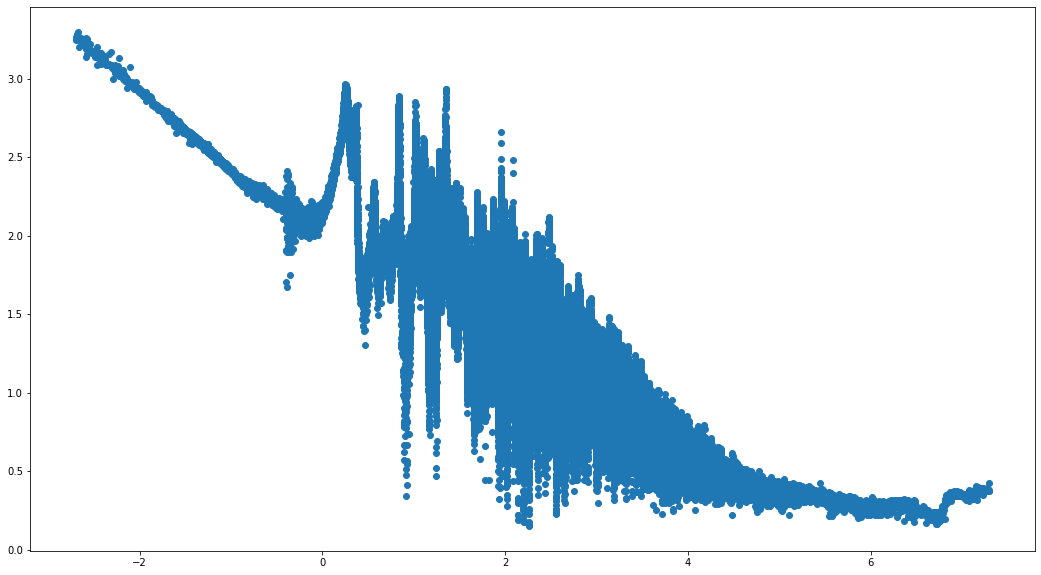

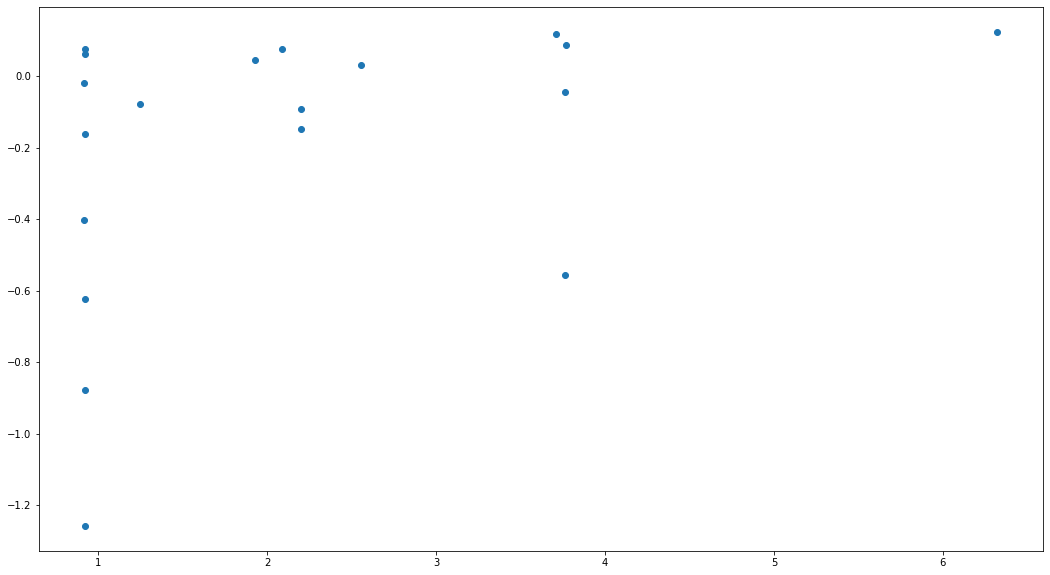

In [270]:
fission = uranium_233[uranium_233.MT == "18"]
fission, deleted = eliminiate_min_datapoints(fission, 19, show=True, show_deleted=True)

In [271]:
# fission = uranium_233[uranium_233.MT == "18"]
# fission = eliminiate_min_campaign(fission, 1, show=True, show_deleted=True)

20 Points Eliminated


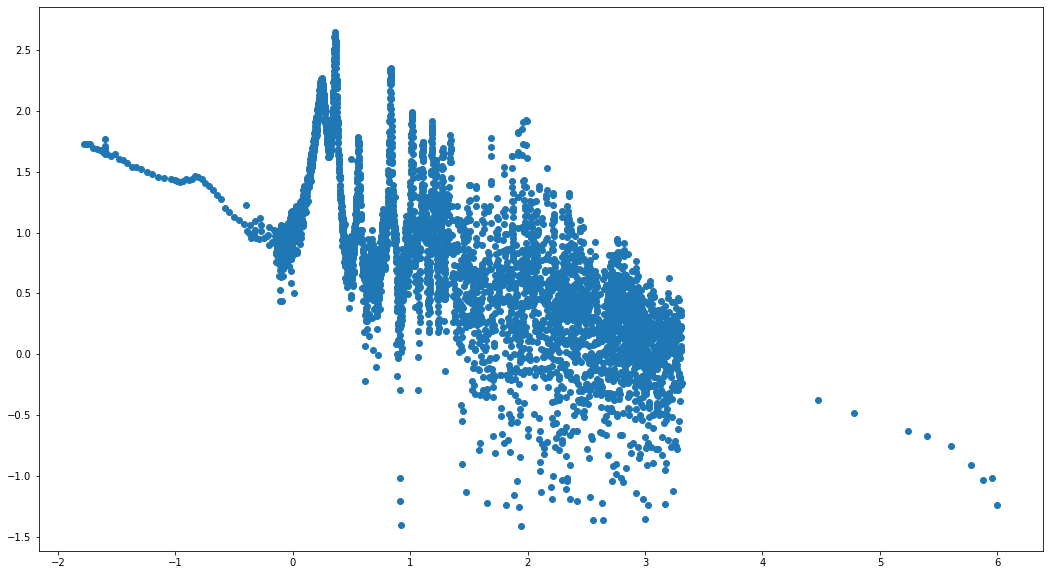

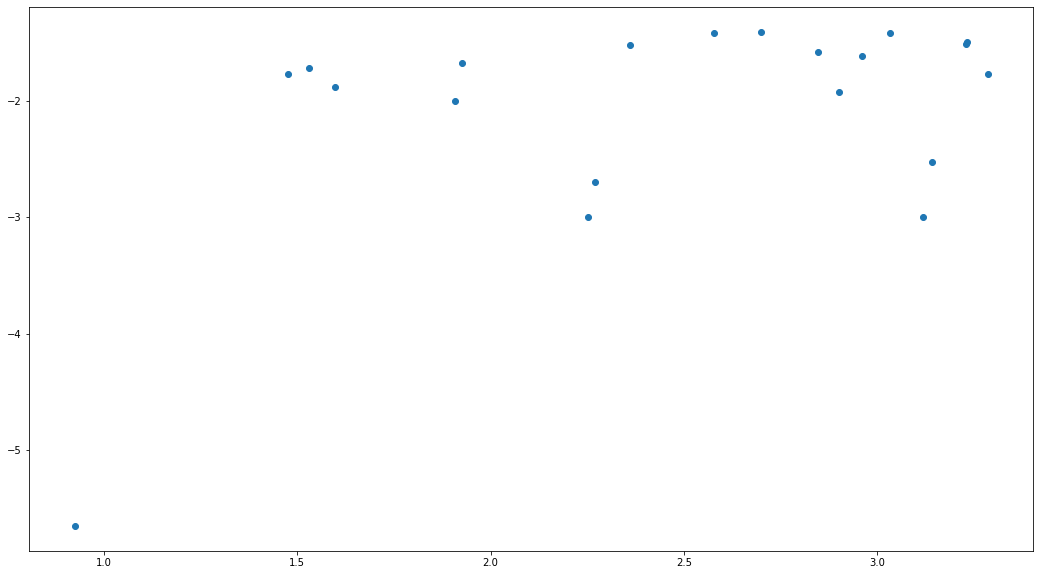

In [272]:
capture = uranium_233[uranium_233.MT == "102"]
capture, deleted = eliminiate_min_datapoints(capture, 20, show=True, show_deleted=True)

In [273]:
# capture = uranium_233[uranium_233.MT == "102"]
# capture = eliminiate_min_campaign(capture, 1, show=True, show_deleted=True)

In [274]:
# capture = eliminiate_min_campaign(capture, 1, show=True, show_deleted=True)

In [275]:
# total = uranium_233[uranium_233.MT == "1"]
# total, deleted = eliminiate_min_datapoints(total, 350, show=True, show_deleted=True)

15160 Points Eliminated


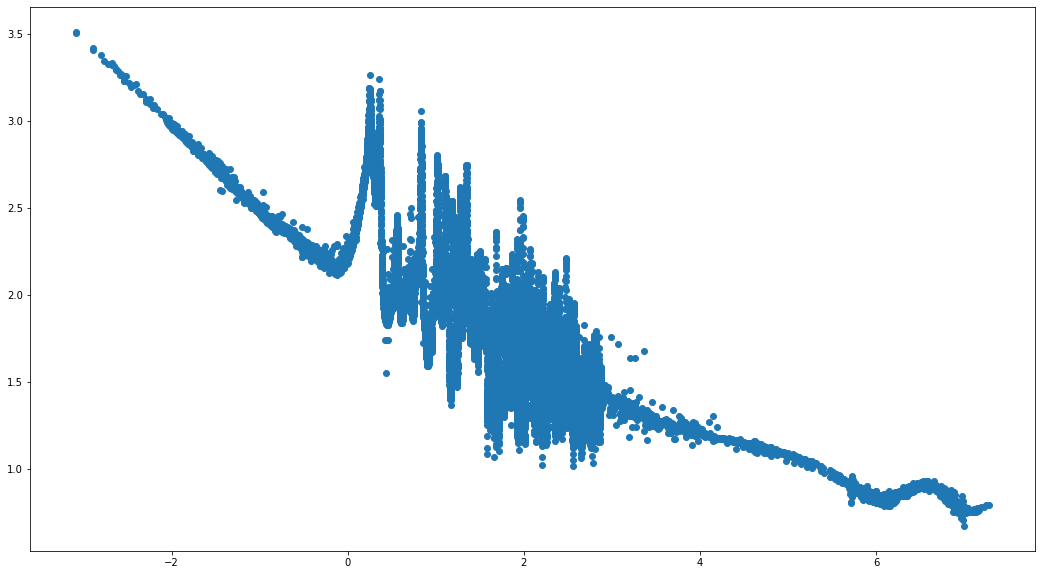

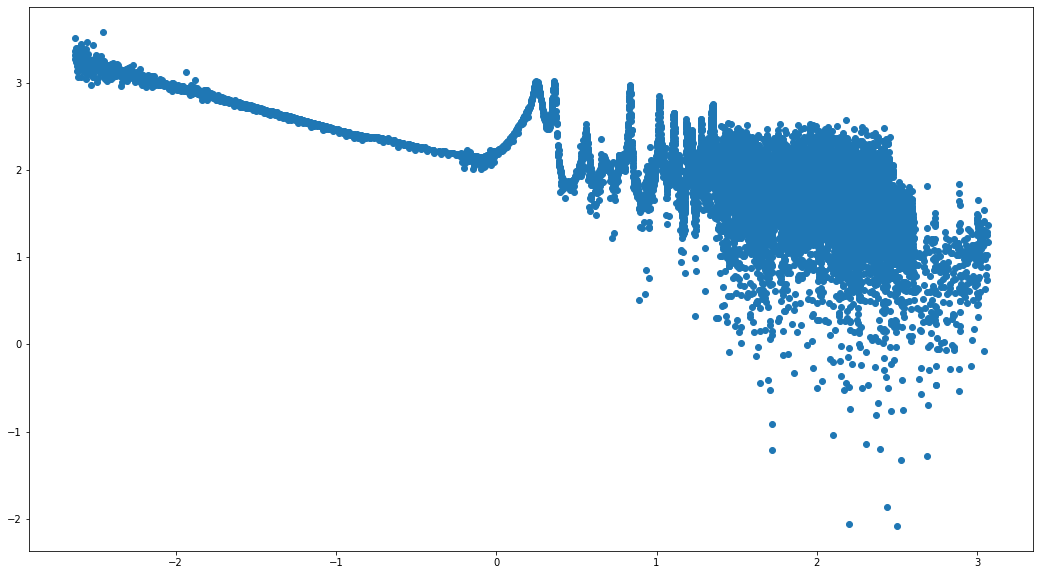

In [276]:
total = uranium_233[uranium_233.MT == "1"]
total = eliminiate_min_campaign(total, 1, show=True, show_deleted=True)

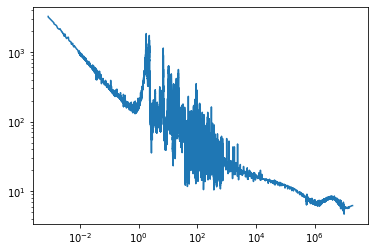

In [278]:
plt.loglog(total.Energy, total.Data)

In [279]:
df_safe = df.copy()

In [257]:
df = df_safe.copy()

In [280]:
def remove_from_df(df, Z, A, MT, MT_df):
    print(df.shape)
    df = df[~((df.Z == Z) & (df.A == A) & (df.MT == MT))]
    print(df.shape)
    df = df.append(MT_df)
    return df

In [281]:
new_df = remove_from_df(df, 92, 233, "1", total)

(4184115, 104)
(4150731, 104)


In [282]:
uranium_233_new =  exfor_utils.load_isotope(new_df, 92, 233)

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (117668, 104)


1 Points Eliminated


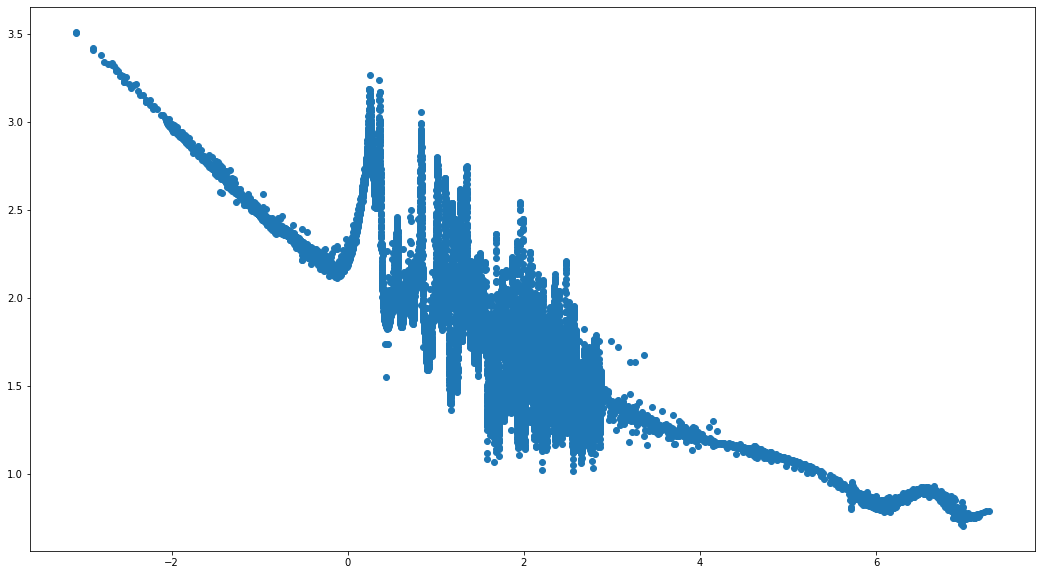

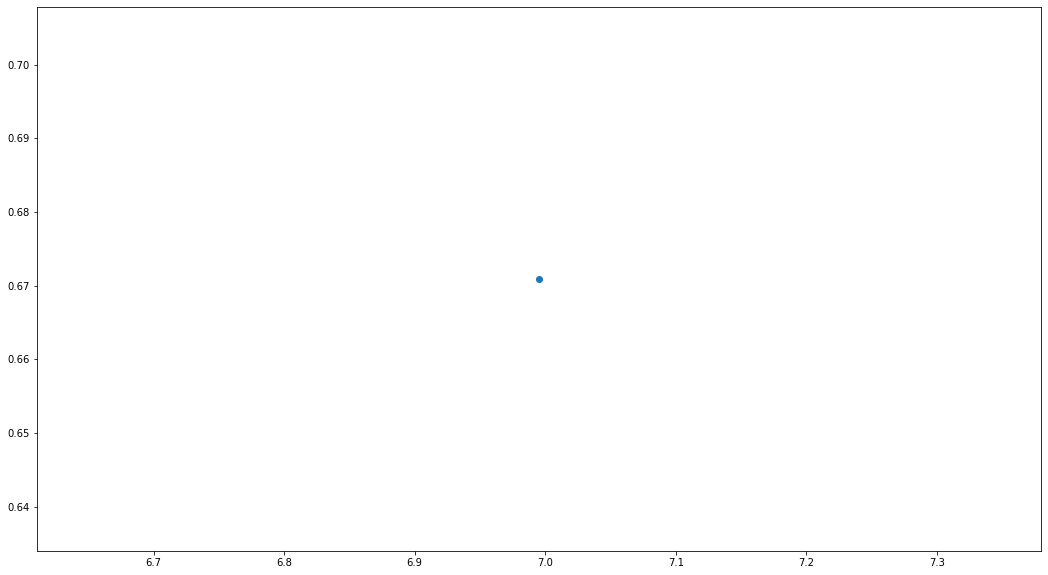

In [283]:
total = uranium_233_new[uranium_233_new.MT == "1"]
total, deleted = eliminiate_min_datapoints(total, 1, show=True, show_deleted=True)